### Libraries and data loading

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.4.1
available gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
available cpus: 128


In [3]:
# define the data location and load data
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
data_folder = os.path.join(pardir,"data","data_forecast")
data_path = os.path.join(data_folder, "forecast_dataset.hdf5")

# !change model name for different models!
model_name = 'SUNSET_forecast_2017_2019_data'
output_folder = os.path.join(pardir,"model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/data/data_forecast
data_path: /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/data/data_forecast/forecast_dataset.hdf5
output_folder: /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data


In [4]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (3 members)>
<HDF5 dataset "images_log": shape (12248, 16, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (12248, 16), type "<f8">
<HDF5 dataset "pv_pred": shape (12248,), type "<f8">
<HDF5 group "/trainval" (3 members)>
<HDF5 dataset "images_log": shape (149680, 16, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (149680, 16), type "<f8">
<HDF5 dataset "pv_pred": shape (149680,), type "<f8">


In [5]:
print('-'*50)
# get the input dimension for constructing the model
# the input images will be reshaped from (None, 16, 64, 64, 3) to (None, 64, 64, 24)
img_side_len = forecast_dataset['trainval']['images_log'].shape[2]
num_log_term = forecast_dataset['trainval']['images_log'].shape[1]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[4]
image_input_dim = [img_side_len,img_side_len,num_log_term*num_color_channel]

print("image side length:", img_side_len)
print("number of log terms:", num_log_term)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

--------------------------------------------------
image side length: 64
number of log terms: 16
number of color channels: 3
input image dimension: [64, 64, 48]
times_trainval.shape: (149680,)


In [6]:
# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
num_samples = len(times_trainval)
batch_size = num_samples//5
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(num_samples // batch_size):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    if i<num_samples // batch_size-1:
        idxs = indices[start_idx:start_idx + batch_size]
    else:
        idxs = indices[start_idx:]
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    _ = forecast_dataset['trainval']['pv_pred'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
data reading start...
batch 1 samples: 0 to 29935, 20.00% finished, processing time 66.95s
batch 2 samples: 29936 to 59871, 40.00% finished, processing time 57.92s
batch 3 samples: 59872 to 89807, 60.00% finished, processing time 44.08s
batch 4 samples: 89808 to 119743, 80.00% finished, processing time 40.48s
batch 5 samples: 119744 to 149679, 100.00% finished, processing time 49.38s


### Input data pipeline helper functions

In [7]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [8]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [9]:
def process_image(image_data):
    '''
    image data processing: reshaping and normalization
    '''
    ## reshape the image tensor from [None,16,64,64,3] to [None,64,64,48]
    image_data = tf.transpose(image_data,perm=[0,2,3,1,4])
    image_data = tf.reshape(image_data, [image_data.shape[0],image_data.shape[1],image_data.shape[2],-1])

    ## normalize the image to [0,1]
    image_data = tf.image.convert_image_dtype(image_data, tf.float32)

    return image_data

In [10]:
# a mapping function from the indices to the corresponding features and labels 
def data_loader(hdf5_data_path,sample_idx,batch_size=256):
    '''
    input:
    hdf5_data_path: path to hdf5 data file
    sample_idx: 
        for training and validation:
            dayblock shuffled indices with cross-validation split into training and validation
            either training or validation indices will be input
        for testing: the indices are not shuffled
    is_trainval: a flag, True for trainig and validation
    output:
    dataset: dataset for training, validation
    '''

    def mapping_func_py(hdf5_data_path,sample_idx):
        '''
        mapping indices to corresponding images and pviance data in hdf5 (python expression)
        '''
        # convert EagerTensor to str or numpy array
        hdf5_data_path = hdf5_data_path.numpy().decode() 
        # sort the sample indices as hdf5 requires increasing order index for data retrieval
        sample_idx = sorted(sample_idx.numpy())

        with h5py.File(hdf5_data_path,'r') as f:

            # read in the data
            images_log = f['trainval']['images_log'][sample_idx]
            pv_log = f['trainval']['pv_log'][sample_idx]
            pv_pred = f['trainval']['pv_pred'][sample_idx]

            # process image data
            images_log = process_image(images_log)
            
            # convert pv data to tf.tensor
            pv_log = tf.convert_to_tensor(pv_log, dtype=tf.float32)
            pv_pred = tf.convert_to_tensor(pv_pred, dtype=tf.float32)

            return images_log, pv_log, pv_pred

    def mapping_func_tf(hdf5_data_path,sample_idx):
        '''
        a wrapper mapping function to get the nested data structure 
        the output type of tf.py_function cannot be a nested sequence when using a tf.py_function with the tf.data API
        '''
        images_log, pv_log, pv_pred = tf.py_function(func=mapping_func_py,
                                                           inp=[hdf5_data_path, sample_idx], 
                                                           Tout=(tf.float32, tf.float32, tf.float32))
        return (images_log, pv_log), pv_pred
    
    
    # create the indices dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    # shuffle and batch the indices
    idx_ds = idx_ds.shuffle(buffer_size = idx_ds.cardinality().numpy(),seed=0)
    idx_ds = idx_ds.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)
    
    # indices dataset mapping to images and pviance data
    # returning dataset with the following nested structure: (images_log, pv_log), pv_pred
    dataset = idx_ds.map(lambda x: mapping_func_tf(hdf5_data_path,x),
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

### Model architecture

In [11]:
# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

In [12]:
# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = keras.Input(shape=image_input_dim)
    ### input pviance/pv output logs with shape (8)
    x2_in = keras.Input(shape=num_log_term)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)
    x = keras.layers.Concatenate(axis=1)([x, x2_in])

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=[x_in, x2_in],outputs=y_out)

    return model

# show model architecture
sunset_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 48)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 24)   10392       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Model training and validation

Repetition 1 model training started ...
Epoch 1/200
527/527 [==============================] - 378s 715ms/step - loss: 61.2611 - val_loss: 7.8935

Epoch 00001: val_loss improved from inf to 7.89348, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch 2/200
527/527 [==============================] - 377s 716ms/step - loss: 9.1216 - val_loss: 6.1903

Epoch 00002: val_loss improved from 7.89348 to 6.19026, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch 3/200
527/527 [==============================] - 380s 722ms/step - loss: 7.3154 - val_loss: 5.7550

Epoch 00003: val_loss improved from 6.19026 to 5.75499, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetit

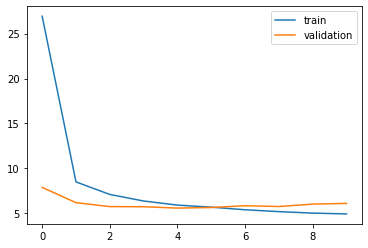

Repetition 2 model training started ...
Epoch 1/200
527/527 [==============================] - 380s 718ms/step - loss: 64.7254 - val_loss: 4.9819

Epoch 00001: val_loss improved from inf to 4.98193, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoch 2/200
527/527 [==============================] - 380s 720ms/step - loss: 9.3402 - val_loss: 3.1528

Epoch 00002: val_loss improved from 4.98193 to 3.15277, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoch 3/200
527/527 [==============================] - 379s 719ms/step - loss: 7.5077 - val_loss: 2.9761

Epoch 00003: val_loss improved from 3.15277 to 2.97610, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetit

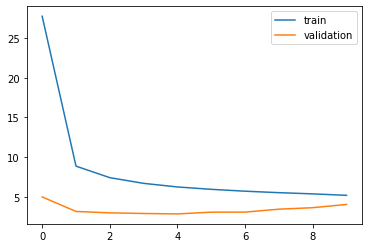

Repetition 3 model training started ...
Epoch 1/200
527/527 [==============================] - 374s 707ms/step - loss: 81.9888 - val_loss: 9.9301

Epoch 00001: val_loss improved from inf to 9.93012, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch 2/200
527/527 [==============================] - 373s 707ms/step - loss: 10.2657 - val_loss: 5.7430

Epoch 00002: val_loss improved from 9.93012 to 5.74303, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch 3/200
527/527 [==============================] - 372s 707ms/step - loss: 7.9979 - val_loss: 5.1491

Epoch 00003: val_loss improved from 5.74303 to 5.14912, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repeti

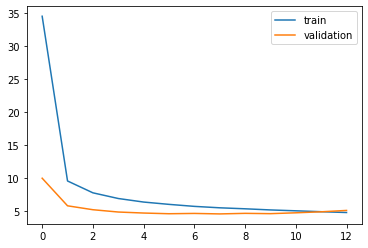

Repetition 4 model training started ...
Epoch 1/200
527/527 [==============================] - 382s 722ms/step - loss: 51.9178 - val_loss: 7.0993

Epoch 00001: val_loss improved from inf to 7.09933, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch 2/200
527/527 [==============================] - 375s 712ms/step - loss: 8.8933 - val_loss: 5.0134

Epoch 00002: val_loss improved from 7.09933 to 5.01343, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch 3/200
527/527 [==============================] - 379s 719ms/step - loss: 7.0559 - val_loss: 4.8308

Epoch 00003: val_loss improved from 5.01343 to 4.83081, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetit

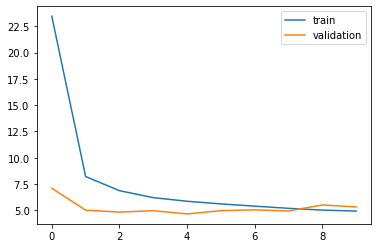

Repetition 5 model training started ...
Epoch 1/200
527/527 [==============================] - 376s 711ms/step - loss: 52.7509 - val_loss: 4.6764

Epoch 00001: val_loss improved from inf to 4.67636, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 2/200
527/527 [==============================] - 374s 709ms/step - loss: 9.1780 - val_loss: 3.5098

Epoch 00002: val_loss improved from 4.67636 to 3.50981, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 3/200
527/527 [==============================] - 374s 709ms/step - loss: 7.5082 - val_loss: 3.2381

Epoch 00003: val_loss improved from 3.50981 to 3.23808, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetit

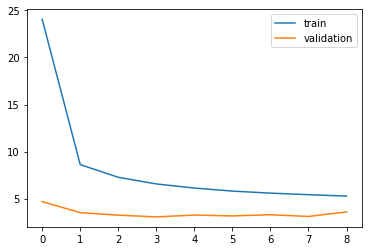

Repetition 6 model training started ...
Epoch 1/200
527/527 [==============================] - 379s 716ms/step - loss: 65.9116 - val_loss: 4.3244

Epoch 00001: val_loss improved from inf to 4.32439, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch 2/200
527/527 [==============================] - 377s 715ms/step - loss: 9.7448 - val_loss: 3.3420

Epoch 00002: val_loss improved from 4.32439 to 3.34205, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch 3/200
527/527 [==============================] - 3886s 7s/step - loss: 7.8682 - val_loss: 2.8487

Epoch 00003: val_loss improved from 3.34205 to 2.84870, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetitio

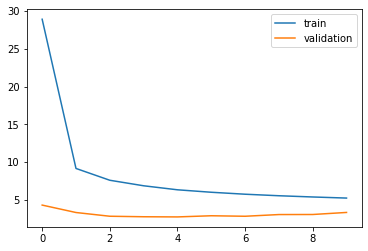

Repetition 7 model training started ...
Epoch 1/200
527/527 [==============================] - 2351s 4s/step - loss: 59.7811 - val_loss: 8.9003

Epoch 00001: val_loss improved from inf to 8.90033, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch 2/200
527/527 [==============================] - 807s 2s/step - loss: 8.9716 - val_loss: 6.0584

Epoch 00002: val_loss improved from 8.90033 to 6.05842, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch 3/200
527/527 [==============================] - 1602s 3s/step - loss: 7.2374 - val_loss: 5.8070

Epoch 00003: val_loss improved from 6.05842 to 5.80701, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_7/b

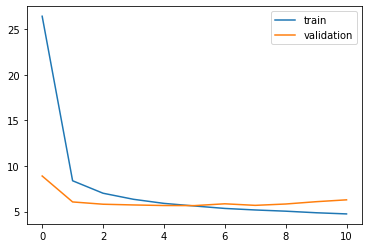

Repetition 8 model training started ...
Epoch 1/200
527/527 [==============================] - 1005s 2s/step - loss: 64.8214 - val_loss: 7.2581

Epoch 00001: val_loss improved from inf to 7.25814, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 2/200
527/527 [==============================] - 710s 1s/step - loss: 9.0646 - val_loss: 5.7705

Epoch 00002: val_loss improved from 7.25814 to 5.77046, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 3/200
527/527 [==============================] - 7412s 14s/step - loss: 7.4276 - val_loss: 5.4842

Epoch 00003: val_loss improved from 5.77046 to 5.48416, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_8/

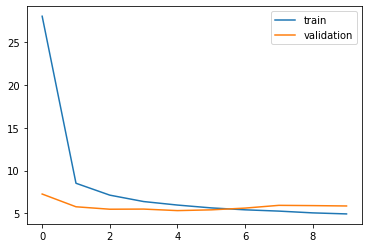

Repetition 9 model training started ...
Epoch 1/200
527/527 [==============================] - 425s 804ms/step - loss: 69.4722 - val_loss: 5.3294

Epoch 00001: val_loss improved from inf to 5.32937, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 2/200
527/527 [==============================] - 425s 807ms/step - loss: 9.4259 - val_loss: 4.1794

Epoch 00002: val_loss improved from 5.32937 to 4.17940, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 3/200
527/527 [==============================] - 426s 808ms/step - loss: 7.6334 - val_loss: 3.7439

Epoch 00003: val_loss improved from 4.17940 to 3.74389, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetit

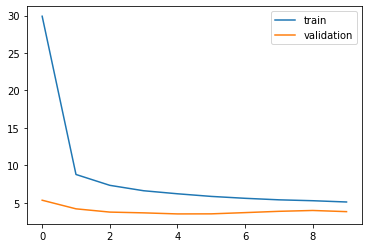

Repetition 10 model training started ...
Epoch 1/200
527/527 [==============================] - 427s 808ms/step - loss: 62.5702 - val_loss: 5.0564

Epoch 00001: val_loss improved from inf to 5.05644, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_10/best_model_repitition_10.h5
Epoch 2/200
527/527 [==============================] - 430s 815ms/step - loss: 9.2244 - val_loss: 3.8502

Epoch 00002: val_loss improved from 5.05644 to 3.85016, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/repetition_10/best_model_repitition_10.h5
Epoch 3/200
527/527 [==============================] - 428s 813ms/step - loss: 7.4991 - val_loss: 3.4962

Epoch 00003: val_loss improved from 3.85016 to 3.49615, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_forecast_2017_2019_data/re

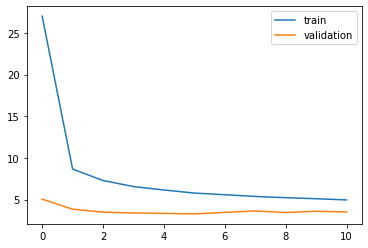

In [14]:
# generate dayblock shuffled indices
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

# initialize loss history list
train_loss_hist = []
val_loss_hist = []
    
for i in range(num_fold):
    
    # construct and compile model for each repetition to reinitialize the model weights
    keras.backend.clear_session()
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),loss='mse')
    
    # implementing 10-fold cross-validation
    print('Repetition {0} model training started ...'.format(i+1))
    
    # creating folder for saving model checkpoint
    save_directory = os.path.join(output_folder,'repetition_'+str(i+1))
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # training and validation data preparation
    ## generate indices dataset for training and validation
    indices_train, indices_val = cv_split(indices_dayblock_shuffled,i,num_fold)
    ## load data from dataloader
    ds_train_batched = data_loader(data_path,indices_train)
    ds_val_batched = data_loader(data_path,indices_val,batch_size=500)

    # define callbacks for training
    ## early stopping rule: if the validation loss stop decreasing for 5 consecutive epoches
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    ## model check point: save model checkpoint for later use
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(save_directory,'best_model_repitition_'+str(i+1)+'.h5'), 
                                monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # training the model and record training and validation loss
    history = model.fit(ds_train_batched, epochs=num_epochs, steps_per_epoch=len(indices_train)//batch_size+1,
                               verbose=1, callbacks=[earlystop,checkpoint], validation_data=ds_val_batched,
                              validation_steps=len(indices_val)//batch_size+1)
    train_loss_hist.append(history.history['loss'])
    val_loss_hist.append(history.history['val_loss'])

    # plot training and validation history
    plt.plot(train_loss_hist[i],label='train')
    plt.plot(val_loss_hist[i],label='validation')
    plt.legend()
    plt.show()

    # saving model training and validation loss history
    np.save(os.path.join(output_folder,'train_loss_hist.npy'),train_loss_hist)
    np.save(os.path.join(output_folder,'val_loss_hist.npy'),val_loss_hist)

In [15]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 2.43, validation loss: 2.36 (RMSE)
Model 2  -- train loss: 2.50, validation loss: 1.69 (RMSE)
Model 3  -- train loss: 2.33, validation loss: 2.12 (RMSE)
Model 4  -- train loss: 2.42, validation loss: 2.16 (RMSE)
Model 5  -- train loss: 2.56, validation loss: 1.75 (RMSE)
Model 6  -- train loss: 2.52, validation loss: 1.66 (RMSE)
Model 7  -- train loss: 2.37, validation loss: 2.38 (RMSE)
Model 8  -- train loss: 2.44, validation loss: 2.31 (RMSE)
Model 9  -- train loss: 2.49, validation loss: 1.87 (RMSE)
Model 10  -- train loss: 2.41, validation loss: 1.81 (RMSE)
The mean train loss (RMSE) for all models is 2.45
The mean validation loss (RMSE) for all models is 2.01


### Model testing

In [4]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]
    pv_pred_test = f['test']['pv_pred'][...]

# process image data
images_log_test = np.transpose(images_log_test,axes=[0,2,3,1,4])
images_log_test = np.reshape(images_log_test, [images_log_test.shape[0],images_log_test.shape[1],images_log_test.shape[2],-1])
images_log_test = (images_log_test/255.0).astype('float32')
    
print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
print("pv_pred_test.shape:",pv_pred_test.shape)

times_test.shape: (12248,)
images_log_test.shape: (12248, 64, 64, 48)
pv_log_test.shape: (12248, 16)
pv_pred_test.shape: (12248,)


In [19]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)
    
    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=[images_log_test,pv_log_test], y=pv_pred_test, batch_size=200, verbose=1)
    
    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict([images_log_test,pv_log_test], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction 
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_pred_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
62/62 [==============================] - 10s 152ms/step - loss: 9.5710
generating predictions for the model
62/62 [==============================] - 12s 173ms/step
loading repetition 2 model ...
evaluating performance for the model
62/62 [==============================] - 10s 152ms/step - loss: 9.3878
generating predictions for the model
62/62 [==============================] - 9s 148ms/step
loading repetition 3 model ...
evaluating performance for the model
62/62 [==============================] - 11s 177ms/step - loss: 9.0526
generating predictions for the model
62/62 [==============================] - 10s 151ms/step
loading repetition 4 model ...
evaluating performance for the model
62/62 [==============================] - 10s 152ms/step - loss: 9.6000
generating predictions for the model
62/62 [==============================] - 9s 146ms/step
loading repetition 5 model ...
evaluating performance for the model
62/62 

In [6]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_pred_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_pred_test_sunny = pv_pred_test[mask]
pv_log_test_sunny = pv_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_pred_test_cloudy = pv_pred_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6197,)
times_test_cloudy.shape: (6051,)


In [7]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_pred_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_pred_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_pred_test_sunny)+rmse_cloudy**2*len(pv_pred_test_cloudy))/(len(pv_pred_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.612
test set cloudy days RMSE: 4.265
test set overall RMSE: 3.029


In [8]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_pred_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_pred_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_pred_test_cloudy) + mae_sunny*len(pv_pred_test_sunny))/(len(pv_pred_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.495
test set cloudy days MAE: 2.952
test set overall MAE: 1.709


In [32]:
# forecast skill for sunny and cloudy days individually
## calculate the rmse of persistent model
from Relative_op_func import *

ntimes = times_test.shape[0]
per_prediction = np.zeros(ntimes)
for i in range(ntimes):
    CSI_cur, P_theo_cur = Relative_output(times_test[i],pv_log_test[i][0])
    CSI, P_theo_pred = Relative_output(times_test[i]+datetime.timedelta(minutes=15),pv_pred_test[i])
    per_prediction[i] = CSI_cur*P_theo_pred

per_prediction_sunny = per_prediction[mask]
per_prediction_cloudy = per_prediction[~mask]

per_rmse_sunny = np.sqrt(np.mean(np.square((per_prediction_sunny-pv_pred_test_sunny))))
per_rmse_cloudy = np.sqrt(np.mean(np.square((per_prediction_cloudy-pv_pred_test_cloudy))))
per_rmse_overall = np.sqrt((per_rmse_sunny**2*len(pv_pred_test_sunny)+per_rmse_cloudy**2*len(pv_pred_test_cloudy))/(len(pv_pred_test)))
print("test set sunny days RMSE persistence: {0:.3f}".format(per_rmse_sunny))
print("test set cloudy days RMSE persistence: {0:.3f}".format(per_rmse_cloudy))
print("test set overall RMSE persistence: {0:.3f}".format(per_rmse_overall))

## calculate the forecasting skills
forecast_skill_sunny = 1 - rmse_sunny/per_rmse_sunny
forecast_skill_cloudy = 1 - rmse_cloudy/per_rmse_cloudy
forecast_skill_overall = 1 - rmse_overall/per_rmse_overall
print("test set sunny days forecast skill: {0:.2f}%".format(forecast_skill_sunny*100))
print("test set cloudy days forecast skill: {0:.2f}%".format(forecast_skill_cloudy*100))
print("test set overall forecast skill: {0:.2f}%".format(forecast_skill_overall*100))

test set sunny days RMSE persistence: 0.420
test set cloudy days RMSE persistence: 5.140
test set overall RMSE persistence: 3.625
test set sunny days forecast skill: -45.80%
test set cloudy days forecast skill: 17.03%
test set overall forecast skill: 16.44%


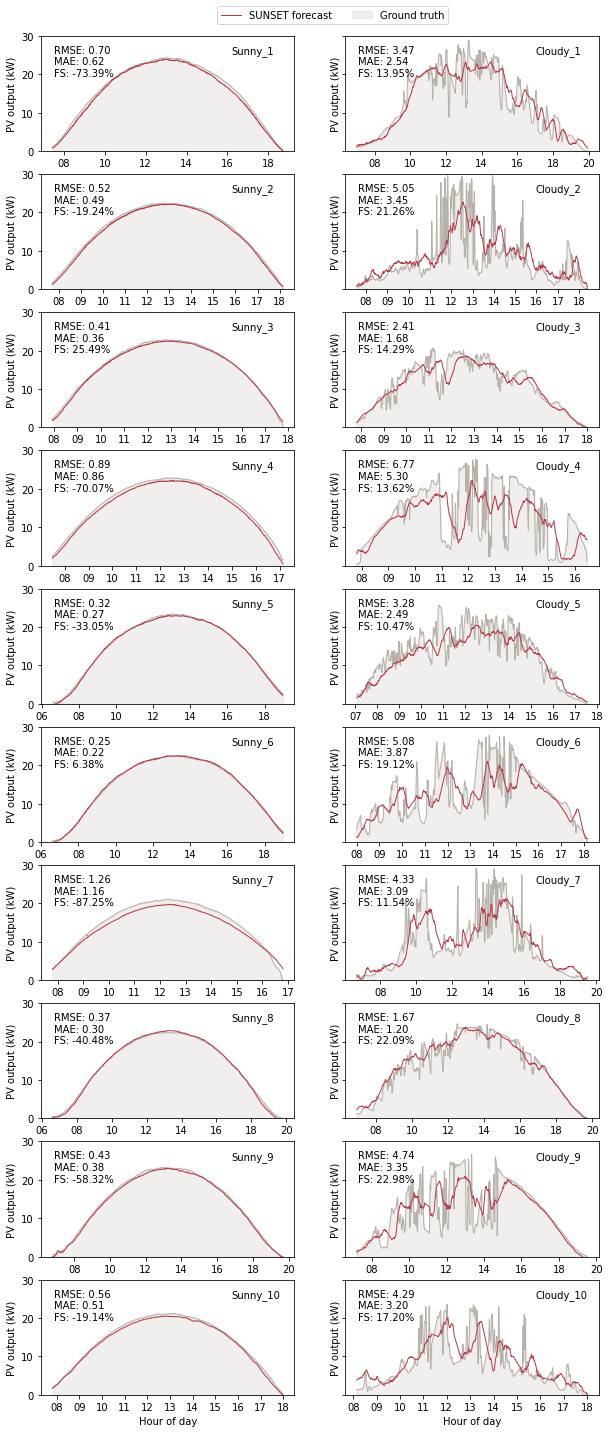

In [33]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-prediction_ensemble[date_mask])))
    per_rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-per_prediction[date_mask]))))
    fs = (1 - rmse/per_rmse)*100
    
    ax.plot(hours_xaxis, pv_pred_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_pred_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET forecast',color=red,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-prediction_ensemble[date_mask])))
    per_rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-per_prediction[date_mask]))))
    fs = (1 - rmse/per_rmse)*100
    
    ax.plot(hours_xaxis, pv_pred_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_pred_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET forecast',color=red,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)

    
axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)    
plt.show()  